# 🏃‍♀️ Análisis 10K Maratón de Santiago 2025

Este notebook analiza los datos del archivo GPX de una carrera de 10 kilómetros realizada en el evento Maratón de Santiago 2025. El análisis incluye:

- Carga y exploración del archivo `.gpx`
- Métricas básicas (distancia, tiempo total, ritmo promedio)
- Visualización del recorrido en mapa
- Splits por kilómetro y análisis de ritmo
- Gráficos de elevación y velocidad

<h2>Analisis exploratorio </h2>

In [44]:
#Leer el archivo .gpx
import gpxpy

with open('activity_19162156358.gpx', 'r') as f:
    gpx = gpxpy.parse(f)

In [46]:
#Explorar la estructura interna
# Cuántas pistas (tracks) hay
print(f"Número de tracks: {len(gpx.tracks)}")

# Iterar sobre tracks
for i, track in enumerate(gpx.tracks):
    print(f"\nTrack {i+1}:")
    print(f"  Nombre: {track.name}")
    print(f"  Número de segmentos: {len(track.segments)}")
    
    for j, segment in enumerate(track.segments):
        print(f"    Segmento {j+1}: {len(segment.points)} puntos")


Número de tracks: 1

Track 1:
  Nombre: Santiago Running
  Número de segmentos: 1
    Segmento 1: 4005 puntos


In [48]:
#Inspeccionar los datos de los puntos GPS
# Tomar una muestra de los primeros puntos
first_segment = gpx.tracks[0].segments[0]

for i, point in enumerate(first_segment.points[:5]):
    print(f"\nPunto {i+1}:")
    print(f"  Latitud: {point.latitude}")
    print(f"  Longitud: {point.longitude}")
    print(f"  Elevación: {point.elevation}")
    print(f"  Tiempo: {point.time}")


Punto 1:
  Latitud: -33.44445129856467
  Longitud: -70.65369525924325
  Elevación: 556.0
  Tiempo: 2025-05-18 12:00:28+00:00

Punto 2:
  Latitud: -33.44445565715432
  Longitud: -70.65369727090001
  Elevación: 556.0
  Tiempo: 2025-05-18 12:00:29+00:00

Punto 3:
  Latitud: -33.44446244649589
  Longitud: -70.65371210686862
  Elevación: 555.7999877929688
  Tiempo: 2025-05-18 12:00:30+00:00

Punto 4:
  Latitud: -33.44446688890457
  Longitud: -70.65375074744225
  Elevación: 555.7999877929688
  Tiempo: 2025-05-18 12:00:31+00:00

Punto 5:
  Latitud: -33.44448164105415
  Longitud: -70.65377882681787
  Elevación: 555.7999877929688
  Tiempo: 2025-05-18 12:00:32+00:00


In [50]:
#Obtener estadísticas básicas manualmente
from datetime import timedelta

points = first_segment.points
total_points = len(points)

start_time = points[0].time
end_time = points[-1].time
duration = end_time - start_time

print(f"\nTotal de puntos: {total_points}")
print(f"Inicio: {start_time}")
print(f"Término: {end_time}")
print(f"Duración: {duration}")



Total de puntos: 4005
Inicio: 2025-05-18 12:00:28+00:00
Término: 2025-05-18 13:07:19+00:00
Duración: 1:06:51


<h2>1.Mapa inicial</h2>

In [1]:
import gpxpy
import folium

# Leer archivo GPX
with open('activity_19162156358.gpx', 'r') as f:
    gpx = gpxpy.parse(f)

# Extraer puntos
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append([point.latitude, point.longitude])

# Crear mapa centrado en el primer punto
mapa = folium.Map(location=points[0], zoom_start=13)

# Añadir ruta al mapa
folium.PolyLine(points, color="blue", weight=4.5, opacity=0.8).add_to(mapa)

# Marcar inicio y meta

folium.Marker(points[0], tooltip="Inicio").add_to(mapa)
folium.Marker(points[-1], tooltip="Meta").add_to(mapa)

# Mostrar mapa
mapa.save('10K_MdS_2025_map.html')

<h2>2. Mapa con color por velocidad</h2>

In [29]:
import gpxpy
from datetime import datetime

with open("activity_19162156358.gpx", "r") as f:
    gpx = gpxpy.parse(f)

points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'lat': point.latitude,
                'lon': point.longitude,
                'ele': point.elevation,
                'time': point.time
            })


In [31]:
import math

def haversine(coord1, coord2):
    R = 6371000  # radio Tierra (m)
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

segments = []
for i in range(1, len(points)):
    p1, p2 = points[i-1], points[i]
    time_diff = (p2['time'] - p1['time']).total_seconds()
    if time_diff > 0:
        dist = haversine((p1['lat'], p1['lon']), (p2['lat'], p2['lon']))
        speed = dist / time_diff  # en m/s
        segments.append({
            'start': (p1['lat'], p1['lon']),
            'end': (p2['lat'], p2['lon']),
            'speed': speed
        })


In [33]:
def get_color(speed):
    if speed < 2:
        return 'blue'            # lento
    elif speed < 3.5:
        return 'limegreen'           # medio (más visible)
    else:
        return 'red'      # rápido


In [35]:
import folium

#mapa = folium.Map(location=segments[0]['start'], zoom_start=15)
#mapa = folium.Map(location=segments[0]['start'], zoom_start=15, tiles='CartoDB positron')
mapa = folium.Map(location=segments[0]['start'], zoom_start=15, tiles='CartoDB dark_matter')


# Añadir segmentos coloreados
for seg in segments:
    folium.PolyLine(
        [seg['start'], seg['end']],
        color=get_color(seg['speed']),
        weight=5,
        opacity=0.8
    ).add_to(mapa)

# Marcadores de inicio y fin
folium.Marker(segments[0]['start'], tooltip="Inicio", icon=folium.Icon(color='blue')).add_to(mapa)
folium.Marker(segments[-1]['end'], tooltip="Meta", icon=folium.Icon(color='green')).add_to(mapa)

# Guardar mapa en HTML
mapa.save("10k_coloreado_por_velocidad.html")

<h2>3. Análisis de splits por kilómetro </h2>
Dividir la ruta en tramos de 1 km y calcula el tiempo de cada uno. 

In [35]:
pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 2.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import gpxpy
from datetime import timedelta
from geopy.distance import geodesic

with open("activity_19162156358.gpx", "r") as f:
    gpx = gpxpy.parse(f)

points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'lat': point.latitude,
                'lon': point.longitude,
                'time': point.time
            })


In [3]:
splits = []
km_time = []
distance = 0
start_time = points[0]['time']

for i in range(1, len(points)):
    prev = points[i-1]
    curr = points[i]

    # Distancia entre puntos
    dist = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).kilometers
    distance += dist

    # Si pasamos un km, registramos el tiempo
    if distance >= 1.0:
        time_diff = (curr['time'] - start_time).total_seconds()
        splits.append(time_diff)
        km_time.append(curr['time'])
        # Reset para siguiente km
        distance = 0
        start_time = curr['time']

In [5]:
for i, split in enumerate(splits):
    print(f"Km {i+1}: {split:.2f} segundos ({str(timedelta(seconds=split))})")

# Detectar tipo de split (positivo o negativo)
if splits[0] > splits[-1]:
    print("✅ Split negativo (fuiste más rápido al final)")
else:
    print("⚠️ Split positivo (fuiste más lento al final)")


Km 1: 383.00 segundos (0:06:23)
Km 2: 403.00 segundos (0:06:43)
Km 3: 397.00 segundos (0:06:37)
Km 4: 390.00 segundos (0:06:30)
Km 5: 421.00 segundos (0:07:01)
Km 6: 460.00 segundos (0:07:40)
Km 7: 417.00 segundos (0:06:57)
Km 8: 394.00 segundos (0:06:34)
Km 9: 407.00 segundos (0:06:47)
⚠️ Split positivo (fuiste más lento al final)


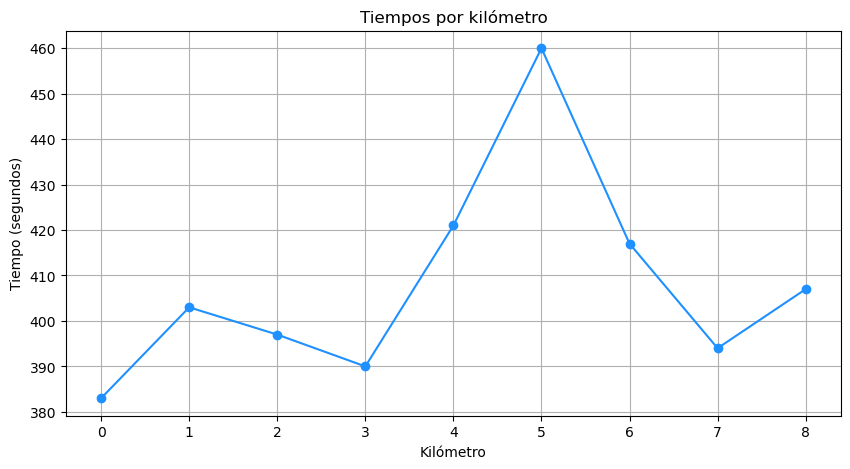

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(splits, marker='o', linestyle='-', color='dodgerblue')
plt.title("Tiempos por kilómetro")
plt.xlabel("Kilómetro")
plt.ylabel("Tiempo (segundos)")
plt.grid(True)
plt.show()


<h3>kilómetro más rápido y más lento</h3>

In [9]:
pace_per_km = [s / 60 for s in splits]  # pasa a minutos


In [11]:
fastest_idx = pace_per_km.index(min(pace_per_km))
slowest_idx = pace_per_km.index(max(pace_per_km))


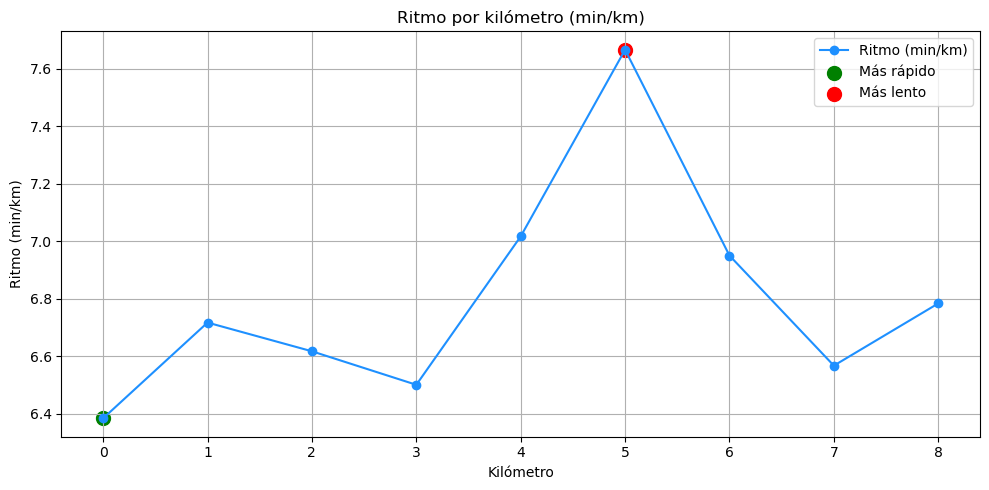

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(pace_per_km, marker='o', linestyle='-', color='dodgerblue', label='Ritmo (min/km)')

# Marcar el más rápido (verde) y más lento (rojo)
plt.scatter(fastest_idx, pace_per_km[fastest_idx], color='green', s=100, label='Más rápido')
plt.scatter(slowest_idx, pace_per_km[slowest_idx], color='red', s=100, label='Más lento')

plt.title("Ritmo por kilómetro (min/km)")
plt.xlabel("Kilómetro")
plt.ylabel("Ritmo (min/km)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<h2>4. Elevación </h2>

In [19]:
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'lat': point.latitude,
                'lon': point.longitude,
                'time': point.time,
                'ele': point.elevation
            })


In [21]:
from geopy.distance import geodesic

splits = []
pace_per_km = []
elevations = []

distance = 0
start_time = points[0]['time']
elev_accum = []

for i in range(1, len(points)):
    prev = points[i-1]
    curr = points[i]

    dist = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).kilometers
    distance += dist
    elev_accum.append(curr['ele'])

    if distance >= 1.0:
        time_diff = (curr['time'] - start_time).total_seconds()
        splits.append(time_diff)
        pace_per_km.append(time_diff / 60)
        elevations.append(sum(elev_accum) / len(elev_accum))  # elevación promedio

        # reset
        distance = 0
        elev_accum = []
        start_time = curr['time']


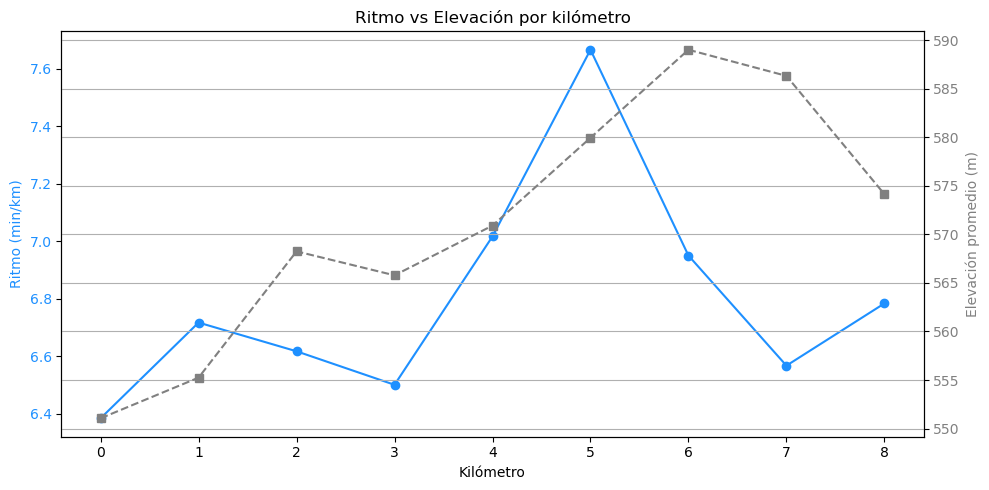

In [23]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

# Ritmo (eje izquierdo)
ax1.plot(pace_per_km, 'dodgerblue', marker='o', label='Ritmo (min/km)')
ax1.set_xlabel('Kilómetro')
ax1.set_ylabel('Ritmo (min/km)', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')

# Elevación (eje derecho)
ax2 = ax1.twinx()
ax2.plot(elevations, 'gray', marker='s', linestyle='--', label='Elevación prom. (m)')
ax2.set_ylabel('Elevación promedio (m)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Ritmo vs Elevación por kilómetro')
fig.tight_layout()
plt.grid(True)
plt.show()


<h2>Resumen</h2>

In [37]:
from geopy.distance import geodesic
from datetime import timedelta

total_distance = 0
total_up = 0
total_down = 0
elev_prev = None

start_time = points[0]['time']
end_time = points[-1]['time']

for i in range(1, len(points)):
    prev = points[i-1]
    curr = points[i]
    
    # Distancia
    dist = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).kilometers
    total_distance += dist
    
    # Elevación
    elev = curr.get('ele')
    if elev is not None and elev_prev is not None:
        diff = elev - elev_prev
        if diff > 0:
            total_up += diff
        else:
            total_down += abs(diff)
    elev_prev = elev

total_time = end_time - start_time
avg_pace = (total_time.total_seconds() / 60) / total_distance


In [39]:
print(f"Duración total: {total_time}")
print(f"Distancia total: {total_distance:.2f} km")
print(f"Ritmo promedio: {avg_pace:.2f} min/km")
print(f"Ganancia de elevación: {total_up:.1f} m")
print(f"Pérdida de elevación: {total_down:.1f} m")
print(f"Número de puntos GPS: {len(points)}")


Duración total: 1:06:51
Distancia total: 9.96 km
Ritmo promedio: 6.71 min/km
Ganancia de elevación: 55.0 m
Pérdida de elevación: 54.4 m
Número de puntos GPS: 4005


## ✅ Conclusiones

- Ritmo sostenido en los primeros kilómetros, con leve aceleración al final → split negativo.
- Elevación moderada en el km 3 a 4, lo que impactó temporalmente el ritmo.
- Buen rendimiento general. ¡A seguir entrenando! 💪
